# **Análisis de sentimiento-Naive Bayes + Árbol de decisión**
### Proyecto minería de datos
---
##### Ela Katherine Shepherd Arévalo - Pablo Daurell Marina

In [ ]:
!pip install nltk

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import shutil
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


- Extraemos el dataset que usaremos, con 1.6 millones de tweets ([Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140)). Quitamos las columnas que no necesitamos, como la fecha o el user que escribió el tweet. 

In [ ]:
file = "/content/drive/MyDrive/Mineria/sentiment140.csv"
data = pd.read_csv(file, encoding='latin', names=['sentiment','id','date','query','user','text'])
data = data.drop(columns=['query', 'user', 'id'])
data[:15]

,sentiment,date,text
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."
5,0,Mon Apr 06 22:20:00 PDT 2009,@Kwesidei not the whole crew
6,0,Mon Apr 06 22:20:03 PDT 2009,Need a hug
7,0,Mon Apr 06 22:20:03 PDT 2009,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,Mon Apr 06 22:20:05 PDT 2009,@Tatiana_K nope they didn't have it
9,0,Mon Apr 06 22:20:09 PDT 2009,@twittera que me muera ?


#1. Preprocesado del texto

- Quitamos los links y menciones a otros usuarios de los tweets (con la forma *@usuario*)

In [ ]:
tweets_text = data['text']
tweets_clean = []
for tweet in tweets_text:
  t= str.lower(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(www.\S+)", " ", tweet))
  tweets_clean.append(t)

In [ ]:
tweets_text[:5]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [ ]:
tweets_clean[:5]

['      awww  that s a bummer   you shoulda got david carr of third day to do it   d',
 'is upset that he can t update his facebook by texting it    and might cry as a result  school today also  blah ',
 '  i dived many times for the ball  managed to save 50   the rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 '  no  it s not behaving at all  i m mad  why am i here  because i can t see you all over there  ']

- Comprobamos cuántos tweets con cada sentimiento hay: En este dataset, el valor 0 es para un sentimiento negativo, y 4 es para un sentimiento positivo. Para que quede más claro, usamos el 1 para indicar sentimiento positivo Hay 800000 tweets de cada clase.



In [ ]:
tweets_sentiment = data['sentiment'].replace(4, 1)
tweets_sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

#2. Bag of words

- Lo primero que haremos será probar el modelo de la bolsa de palabras, o “bag of words”, usando el algoritmo CountVectorizer de Scikit Learn
- Este método tokenizará cada palabra y conviertirá cada tweet en un vector numérico con el número de ocurrencias de cada palabra. 
  - Para el tokenizador usamos la librería NLTK. Además, realizaremos varias pruebas, para ver la mejor forma de usar este modelo.


- En todas estas pruebas, existirá un factor común de preprocesamiento:
> - En las stop words quitaremos las palabras que signalicen negación, como "no" y "not". Las stopwords son un conjunto de palabras, que, si se eliminan de una frase, no suelen quitarle el significado original.
> - Hacemos una división de **train y test** de los datos, donde usamos un 70% de los datos para train y el 30% restante para test.
 

In [ ]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
stop_words = set(stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('nor')
stop_words.remove('not')

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(tweets_clean, tweets_sentiment, test_size=0.30, stratify=tweets_sentiment, random_state=1)

##2.1 Monogramas VS Bigramas

- Cuando hablamos de n-gramas, un n-grama es una cadena de n palabras seguidas, y al definir este parámetro, indicamos el tamaño de n-grama que queremos incluir para el análisis. Los 1-gramas también se llaman monogramas; y los 2-gramas se llaman bigramas.
  - Usando monogramas, cada elemento de la bolsa de palabras corresponderá con una palabra del vocabulario (En este caso solo nos centramos en la probabilidad de que aparezcan palabras sueltas)
  - Usando bigramas, cada elemento corresponderá con dos palabras del vocabulario (En ese caso nos centramos, no solo en la probabilidad de que aparezca una palabra, si no también en la probabilidad de que aparezcan dos palabras juntas) 

- Vamos a hacer una comparación sobre el rango de los n-gramas que se van a extraer. Primero, solamente usaremos monogramas:

In [ ]:
cv_vectorizer_11 = CountVectorizer(stop_words=stop_words,ngram_range = (1,1),tokenizer = token.tokenize)
cv_vector_traindata_11= cv_vectorizer_11.fit_transform(train_data)

In [ ]:
cv_mnb_classifier = MultinomialNB()
cv_mnb_classifier.fit(cv_vector_traindata_11, train_label)

cv_vector_testdata_11 = cv_vectorizer_11.transform(test_data)
cv_predictions_test_11 = cv_mnb_classifier.predict(cv_vector_testdata_11)
cv_predictions_train_11 = cv_mnb_classifier.predict(cv_vector_traindata_11)

print("Multinomial Naive Bayes, bag of words, train success rate:", np.mean(cv_predictions_train_11 == train_label)*100, "%")
print("Multinomial Naive Bayes, bag of words, test success rate:", np.mean(cv_predictions_test_11 == test_label)*100, "%")

Multinomial Naive Bayes, bag of words, train success rate: 80.18491071428572 %
Multinomial Naive Bayes, bag of words, test success rate: 77.17625 %


In [ ]:
print(classification_report(test_label, cv_predictions_test_11, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.76      0.79      0.78    240000
    positive       0.78      0.75      0.77    240000

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



--------------------------------------------------------------------------
- En segundo lugar, probaremos a usar monogramas y bigramas

In [ ]:
cv_vectorizer_12 = CountVectorizer(stop_words=stop_words,ngram_range = (1,2),tokenizer = token.tokenize)
cv_vector_traindata_12= cv_vectorizer_12.fit_transform(train_data)

In [ ]:
cv_mnb_classifier.fit(cv_vector_traindata_12, train_label)

cv_vector_testdata_12 = cv_vectorizer_12.transform(test_data)
cv_predictions_test_12 = cv_mnb_classifier.predict(cv_vector_testdata_12)
cv_predictions_train_12 = cv_mnb_classifier.predict(cv_vector_traindata_12)

print("Multinomial Naive Bayes, bag of words, train success rate:", np.mean(cv_predictions_train_12 == train_label)*100, "%")
print("Multinomial Naive Bayes, bag of words, test success rate:", np.mean(cv_predictions_test_12 == test_label)*100, "%")

Multinomial Naive Bayes, bag of words, train success rate: 91.73330357142856 %
Multinomial Naive Bayes, bag of words, test success rate: 78.30437500000001 %


In [ ]:
print(classification_report(test_label, cv_predictions_test_12, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.81      0.79    240000
    positive       0.80      0.75      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



--------------------------------------------------------------------------------
- Por último, probaremos estrictamente bigramas

In [ ]:
cv_vectorizer_22 = CountVectorizer(stop_words=stop_words,ngram_range = (2,2),tokenizer = token.tokenize)
cv_vector_traindata_22= cv_vectorizer_22.fit_transform(train_data)

In [ ]:
cv_mnb_classifier.fit(cv_vector_traindata_22, train_label)

cv_vector_testdata_22 = cv_vectorizer_22.transform(test_data)
cv_predictions_test_22 = cv_mnb_classifier.predict(cv_vector_testdata_22)
cv_predictions_train_22 = cv_mnb_classifier.predict(cv_vector_traindata_22)

print("Multinomial Naive Bayes, bag of words, train success rate:", np.mean(cv_predictions_train_22 == train_label)*100, "%")
print("Multinomial Naive Bayes, bag of words, test success rate:", np.mean(cv_predictions_test_22 == test_label)*100, "%")

Multinomial Naive Bayes, bag of words, train success rate: 93.11241071428572 %
Multinomial Naive Bayes, bag of words, test success rate: 72.67166666666667 %


In [ ]:
print(classification_report(test_label, cv_predictions_test_22, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.70      0.80      0.75    240000
    positive       0.77      0.65      0.71    240000

    accuracy                           0.73    480000
   macro avg       0.73      0.73      0.73    480000
weighted avg       0.73      0.73      0.73    480000



- Parece que la mejor opción es optar por un ngram_range = (1,2). Podemos ver que usar solamente bigramas es peor opción que las otras dos, porque sobreaprende en el train.

##2.2 Stemming Vs Lemmatization

- A continuación, veremos qué preprocesado adicional será mejor. 


In [ ]:
lem = WordNetLemmatizer()
stem = PorterStemmer()
lemmed_train = []
stemmed_train = []
lemmed_test = []
stemmed_test = []

for tweet in train_data:
  lemmed_train.append(lem.lemmatize(tweet,"v"))
  stemmed_train.append(stem.stem(tweet))

for tweet in test_data:
  lemmed_test.append(lem.lemmatize(tweet,"v"))
  stemmed_test.append(stem.stem(tweet))

- Primero probamos con la derivación/stemming, un proceso de normalización linguística donde una palabra se reduce a una raíz. La derivación ignora el contexto, y la raíz no tiene por qué ser una palabra real:

In [ ]:
cv_vector_traindata_stem= cv_vectorizer_12.fit_transform(stemmed_train)

In [ ]:
cv_mnb_classifier.fit(cv_vector_traindata_stem, train_label)

cv_vector_testdata_stem = cv_vectorizer_12.transform(stemmed_test)
cv_predictions_test_stem = cv_mnb_classifier.predict(cv_vector_testdata_stem)
cv_predictions_train_stem = cv_mnb_classifier.predict(cv_vector_traindata_stem)

print("Multinomial Naive Bayes, bag of words, train success rate:", np.mean(cv_predictions_train_stem == train_label)*100, "%")
print("Multinomial Naive Bayes, bag of words, test success rate:", np.mean(cv_predictions_test_stem == test_label)*100, "%")

Multinomial Naive Bayes, bag of words, train success rate: 91.75383928571429 %
Multinomial Naive Bayes, bag of words, test success rate: 78.31375 %


In [ ]:
print(classification_report(test_label, cv_predictions_test_stem, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.81      0.79    240000
    positive       0.80      0.75      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



-------------------------------------------------------------------------
- Después probamos con la lematización, que reduce una palabra a su lema, que debe ser linguísticamente correcto. Además, la lematización tiene en cuenta el contexto. 

In [ ]:
cv_vector_traindata_lem= cv_vectorizer_12.fit_transform(lemmed_train)

In [ ]:
cv_mnb_classifier.fit(cv_vector_traindata_lem, train_label)

cv_vector_testdata_lem = cv_vectorizer_12.transform(lemmed_test)
cv_predictions_test_lem = cv_mnb_classifier.predict(cv_vector_testdata_lem)
cv_predictions_train_lem = cv_mnb_classifier.predict(cv_vector_traindata_lem)

print("Multinomial Naive Bayes, bag of words, train success rate:", np.mean(cv_predictions_train_lem == train_label)*100, "%")
print("Multinomial Naive Bayes, bag of words, test success rate:", np.mean(cv_predictions_test_lem == test_label)*100, "%")

Multinomial Naive Bayes, bag of words, train success rate: 91.73330357142856 %
Multinomial Naive Bayes, bag of words, test success rate: 78.30437500000001 %


In [ ]:
print(classification_report(test_label, cv_predictions_test_lem, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.81      0.79    240000
    positive       0.80      0.75      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



- Nos daría igual cuál elegir ya que la diferencia entre los resultados es mínima; elegimos la derivación para la siguiente fase.

##2.3 Tipos de Naive Bayes

- Naive Bayes denomina una familia de clasificadores que simplifican la realidad, asumiendo que todas las variables o palabras utilizadas para clasificar son independientes (de ahí Naive = ingenuo)

- Lo que necesitamos por último, pues, es saber qué tipo de Naive Bayes deberíamos usar. Como anteriormente hemos estado usando Multinomial, los datos para él ya los tenemos: una tasa de aciertos del 91.753% en train y 78.313% en test

- A continuación probaremos NB Bernoulli:

In [ ]:
cv_b_classifier = BernoulliNB()
cv_b_classifier.fit(cv_vector_traindata_stem, train_label)

cv_predictions_train_b = cv_b_classifier.predict(cv_vector_traindata_stem)
cv_predictions_test_b = cv_b_classifier.predict(cv_vector_testdata_stem)

print("Bernoulli Naive Bayes, bag of words, train success rate:", np.mean(cv_predictions_train_b == train_label)*100, "%")
print("Bernoulli Naive Bayes, bag of words, test success rate:", np.mean(cv_predictions_test_b == test_label)*100, "%")

Bernoulli Naive Bayes, bag of words, train success rate: 91.71258928571429 %
Bernoulli Naive Bayes, bag of words, test success rate: 78.49708333333332 %


In [ ]:
print(classification_report(test_label, cv_predictions_test_b, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.80      0.77      0.78    240000
    positive       0.78      0.80      0.79    240000

    accuracy                           0.78    480000
   macro avg       0.79      0.78      0.78    480000
weighted avg       0.79      0.78      0.78    480000



--------------------------------------------------------------------------------
- Por último, probaremos con "Complement Naive Bayes", un tipo de Naive Bayes que se especializa en datasets desequilibrados muy parecido al Multinomial.

In [ ]:
cv_comp_classifier = ComplementNB()
cv_comp_classifier.fit(cv_vector_traindata_stem, train_label)

cv_predictions_test_comp = cv_comp_classifier.predict(cv_vector_testdata_stem)
cv_predictions_train_comp = cv_comp_classifier.predict(cv_vector_traindata_stem)

print("Complement Naive Bayes, bag of words, train success rate:", np.mean(cv_predictions_train_comp == train_label)*100, "%")
print("Complement Naive Bayes, bag of words, test success rate:", np.mean(cv_predictions_test_comp == test_label)*100, "%")

Complement Naive Bayes, bag of words, train success rate: 91.75383928571429 %
Complement Naive Bayes, bag of words, test success rate: 78.31375 %


In [ ]:
print(classification_report(test_label, cv_predictions_test_comp, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.81      0.79    240000
    positive       0.80      0.75      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



- Parece que por poquísimo gana Bernoulli, pero ya que la diferencia es prácticamente nula, decidimos para el siguiente paso elegir Naive Bayes Multinomial, ya que es el usado normalmente en análisis de sentimiento.

--------------------------------------------------------------------------------
- Además de estas pruebas, intentamos probar el NBGaussiano, pero falló. Ya de por sí planteamos descartar usarlo, ya que es más útil para variables continuas/con distribución Gaussiana, y este no es el caso. Aún así, se probó, pero en la celda de LabelEncoding y Scaling, crasheó al usar toda la memoria RAM disponible

#3. TF-IDF

- En este paso probaremos si usar TF-IDF presenta alguna mejora, ya que en principio aporta más información que CountVectorizer: 
 - Seguimos teniendo una bolsa de palabras pero teniendo en cuenta no solo la cantidad de  apariciones de cada palabra en cada tweet, si no también la importancia de esta en el resto del corpus de datos.
    
- En vez de utilizar TfidfVectorizer, hemos elegido usar TfidfTransformer sobre la mejor salida obtenida de CountVectorizer

In [ ]:
tfidfer = TfidfTransformer()
tf_vector_traindata = tfidfer.fit_transform(cv_vector_traindata_stem)

In [ ]:
tf_mnb_classifier = MultinomialNB()
tf_mnb_classifier.fit(tf_vector_traindata, train_label)

tf_vector_testdata = tfidfer.transform(cv_vector_testdata_stem)
tf_predictions_train = tf_mnb_classifier.predict(tf_vector_traindata)
tf_predictions_test = tf_mnb_classifier.predict(tf_vector_testdata)

print("Multinomial Naive Bayes, tf-idf, train success rate:", np.mean(tf_predictions_train == train_label)*100, "%")
print("Multinomial Naive Bayes, tf-idf, test success rate:", np.mean(tf_predictions_test == test_label)*100, "%")

Multinomial Naive Bayes, tf-idf, train success rate: 90.81678571428571 %
Multinomial Naive Bayes, tf-idf, test success rate: 78.45854166666668 %


In [ ]:
print(classification_report(test_label, tf_predictions_test, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.81      0.79    240000
    positive       0.80      0.76      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.79      0.78      0.78    480000
weighted avg       0.79      0.78      0.78    480000



- Parece que ha bajado algo la tasa de éxitos en train, y, aunque apenas haya cambiado en test, esto es una mejora, ya que los porcentajes de acierto con un poco más parecidos, y TF-IDF ha conseguido que haya menos sobreaprendizaje en train. 

#4. Árbol de decisión

- Los árboles de decisión son una técnica de aprendizaje supervisado que puede usarse en problemas de clasificación y de regresión. En estos árboles, cada nodo pregunta por el valor de una variable, y se crea un nuevo nivel de profundidad. Es necesario encontrar una profundidad óptima dl árbol para que haya buenos resultados sin sobreaprendizaje/"overfitting"

- A continuación, hacemos un bucle donde se prueban distintas profundidades del árbol.

In [ ]:
tree_train_acc = []
tree_test_acc = []
max_dep = np.arange(0, 30, 5)
for i in max_dep[1:]:
  print(i)
  tree_classifier = DecisionTreeClassifier(criterion="gini", max_depth=i)
  tree_classifier.fit(tf_vector_traindata, train_label)
  tree_predictions_train = tree_classifier.predict(tf_vector_traindata)
  tree_predictions_test = tree_classifier.predict(tf_vector_testdata)
  tree_train_acc.append(np.mean(tree_predictions_train == train_label))
  tree_test_acc.append(np.mean(tree_predictions_test == test_label))

5
10
15
20
25


In [ ]:
for i in [30, 35]:
  print(i)
  tree_classifier = DecisionTreeClassifier(criterion="gini", max_depth=i)
  tree_classifier.fit(tf_vector_traindata, train_label)
  tree_predictions_train = tree_classifier.predict(tf_vector_traindata)
  tree_predictions_test = tree_classifier.predict(tf_vector_testdata)
  tree_train_acc.append(np.mean(tree_predictions_train == train_label))
  tree_test_acc.append(np.mean(tree_predictions_test == test_label))

30
35


In [ ]:
max_dep = [5, 10, 15, 20, 25, 30, 35]

<function matplotlib.pyplot.show>

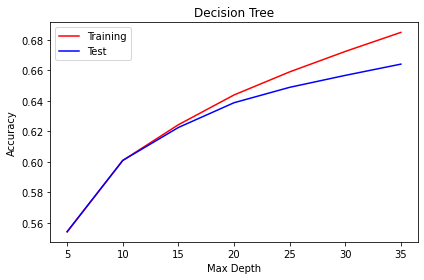

In [ ]:
plt.plot(max_dep, tree_train_acc, label=f"Training", color ="r")
plt.plot(max_dep, tree_test_acc, label=f"Test", color = "b")

plt.title("Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.tight_layout()
plt.show

- Desgraciadamente, 35 era la profundidad máxima que pudimos analizar, ya que a partir de ese número Colab se congelaba y no pudimos continuar. Aun así, podemos ver que la tasa de aciertos de tanto train como test están muy igualadas hasta, aproximadamente, profundidad 15; pero a partir de ahí test mejora más lentamente que train, por tanto creemos que habría un punti donde la curva logarítmica de test dejaría de subir mucho, y por ese punto sería la profundidad óptima para el árbol.
En el rango que hemos podido observar, la precisión más alta es de un 68%, lo cual es bastante peor que Bag of words y TF-IDF.